## Deconvolution

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A better signal model than only a Gaussian spectrum.
  * Background subtraction
  * Acceptance estimate (Current method: a guess based on how the spectra look).

### Load the spectrum from previous notebooks

In [ ]:
from IPython.utils import io
with io.capture_output() as output_07b:
    %run '07b_deconvolution_definitions.ipynb'

### Get response Andreas' method

(1.4, 3.2)

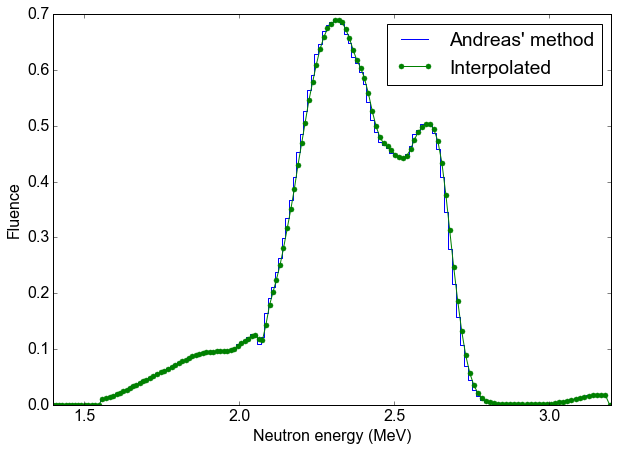

In [6]:
# Interpolate andreas' spectrum to be at the right energies
y_and_interp = np.interp(neutron_energies, e_and, y_and, 0, 0)

# Confirm that all goes well
plt.plot(e_and, 0.5*y_and, linestyle='steps', label = "Andreas' method")
plt.plot(neutron_energies, 0.5*y_and_interp, marker='.', markersize=10, label='Interpolated')
plt.xlabel('Neutron energy (MeV)')
plt.ylabel('Fluence')
plt.legend()
plt.xlim(1.4, 3.2)

In [7]:
and_response = np.zeros(len(electron_energies))
# Loop over all neutron energy bins expect for last one
for i in range(len(neutron_energies) - 1):
    # Current neutron energy
    neutron_energy = neutron_energies[i]
    # Current bin width
    bin_width = neutron_energies[i+1] - neutron_energies[i]
    # Current amplitude in the neutron spectrum
    ampl = 0.5*y_and_interp[i]
    # Full response for this neutron energy bin
    and_response += bin_width*ampl*response[i]

### Data to fit and definition $\chi^2$ functions

Here are the spectra that we can fit:

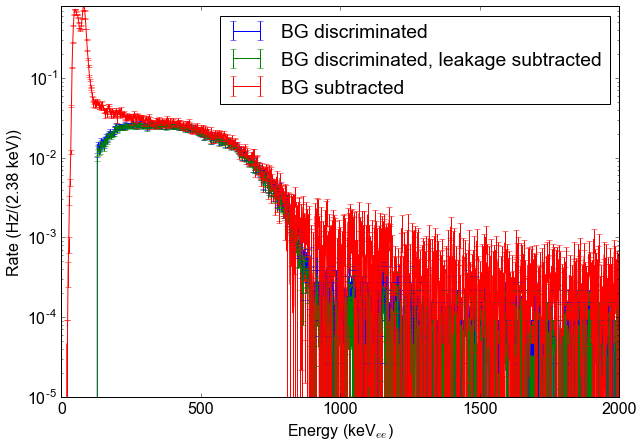

In [8]:
plt.errorbar(e_scale, fg_disc, fg_disc_err, label='BG discriminated')
plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, label='BG discriminated, leakage subtracted')
plt.errorbar(e_scale, fg_sub, fg_sub_err, label= 'BG subtracted')
plt.ylabel('Rate (Hz/(2.38 keV))')

plt.yscale('log')
plt.ylim(0.00001, 0.8)
plt.xlim(0,2000)

# plt.xlim(800,1000)
# plt.ylim(-0.01,0.01)
# plt.axhline(0,color='b')

plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()
plt.show()

In [9]:
from iminuit import Minuit

In [10]:
# Chi^2 function for single Gaussian function in neutron energy
class Chi2Func:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
class Chi2Func_no_err:
    def __init__(self,x,y):
        self.x = x
        self.y_data = y_data

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2)
        return chi2    
    
# Chi^2 function for two Gaussian functions in neutron energy
class Chi2Func_2:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
class Chi2Func_no_err_2:
    def __init__(self,x,y):
        self.x = x
        self.y_data = y_data

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2)
        return chi2    

### Settings for fits

In [11]:
min_e = 500
max_e = 900
use_err = True

### Fit spectrum for BG rejected spectrum

### Fit double Gaussian

In [12]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_disc_sub[sel]
y_err = fg_disc_sub_err[sel]
assert len(fg_disc_sub_err[sel][fg_disc_sub_err[sel] == 0]) == 0

# Initialize chi2 function
if use_err:
    chi2 = Chi2Func_2(x, y_data, y_err)
else:
    chi2 = Chi2Func_no_err_2(x, y_data)

# Give guess parameters
my_args = dict(
    a1=0.15, mu1=2.2, sigma1=0.1, error_a1 = 0.0001, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=0.15, mu2=2.6, sigma2=0.1, error_a2 = 0.0001, error_mu2 = 0.1, error_sigma2 = 0.01,
    errordef=1)
# Initialize minimizer and minimize
m_doub_sub = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m_doub_sub.migrad();
print(m_doub_sub.values)

FCN = 194.83973796002599 
 TOTAL NCALL = 283 
 NCALLS = 283 
 
 
 EDM = 3.259160958747116e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,0.211133,0.040655,0,0,,,
2,mu1,2.3136,0.0309108,0,0,,,
3,sigma1,0.110094,0.0278005,0,0,,,
4,a2,0.0946715,0.0388003,0,0,,,
5,mu2,2.60964,0.0452473,0,0,,,
6,sigma2,0.0775839,0.0293427,0,0,,,


{'mu1': 2.3135968854400066, 'sigma1': 0.11009362966521433, 'mu2': 2.6096446087719047, 'sigma2': 0.0775838851456969, 'a2': 0.09467151533339832, 'a1': 0.21113316522237993}


In [13]:
# THis factor comes from the differnt energy bins. No idea where the 10^4 comes from though...
ad_hoc_factor = (5./2.38)*10**4

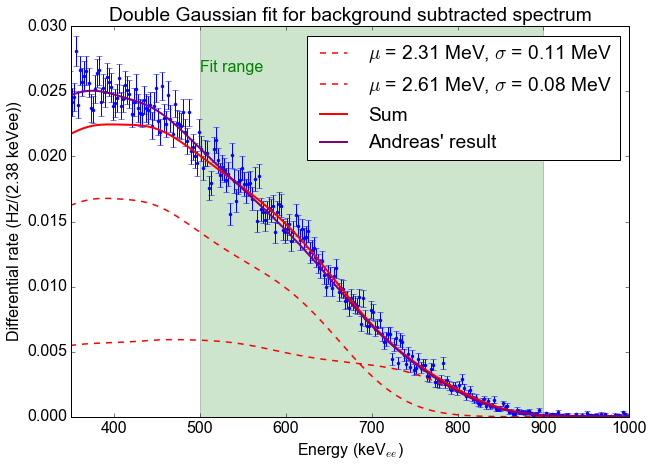

In [14]:
vals = m_doub_sub.values
plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, ls='None', marker='.')
# Take subplots
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a1'], vals['mu1'], vals['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu1'], vals['sigma1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a2'], vals['mu2'], vals['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu2'], vals['sigma2']), ls='--')

plt.plot(e_scale, get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')

# Plot Andreas result
plt.plot(1000*electron_energies, ad_hoc_factor*1/fg_livetime * and_response, color='purple', lw=2, 
         label="Andreas' result")

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.0265, 'Fit range', color='green')

plt.ylim(1e-6,0.3e-1)
plt.xlim(350,1000)
plt.legend()
#plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Double Gaussian fit for background subtracted spectrum')

plt.savefig('plots/fit_spectrum_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

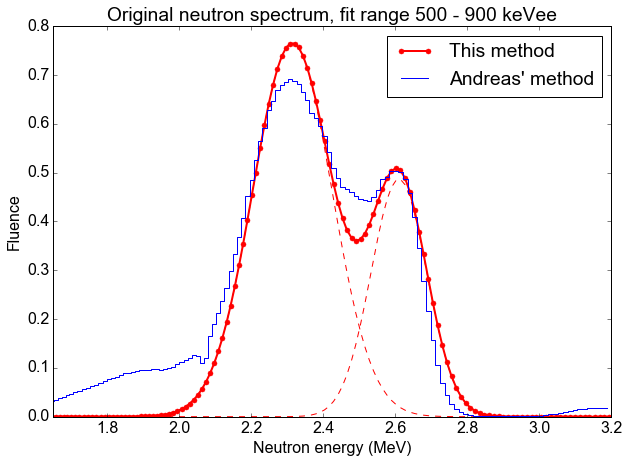

In [15]:
vals = m_doub_sub.values
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']) +
         vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',lw=2,
         marker='.', markersize=10, label='This method')
plt.xlim(1.65, 3.2)
plt.title('Original neutron spectrum, fit range %d - %d keVee' % (min_e, max_e))

plt.plot(e_and, 0.5*y_and, linestyle='steps', label = "Andreas' method")
plt.xlabel('Neutron energy (MeV)')
plt.ylabel('Fluence')
plt.legend()

plt.savefig('plots/neut_spectrum_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

#### Single Gaussian

In [16]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_disc_sub[sel]
y_err = fg_disc_sub_err[sel]
assert len(fg_disc_sub_err[sel][fg_disc_sub_err[sel] == 0]) == 0

# Initialize chi2 function
if use_err:
    chi2 = Chi2Func(x, y_data, y_err)
else:
    chi2 = Chi2Func_no_err(x, y_data)

# Give guess parameters
my_args = dict(
    a=0.3, mu=2.4, sigma=0.196, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)

# m: minimizer; sing: single Gaussian; sub: subtracted the background
m_sing_sub = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_sing_sub.migrad();
print(m_sing_sub.values)

FCN = 220.61710453796204 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 1.0657100979486252e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.31278,0.00324888,0,0,,,
2,mu,2.39479,0.00453244,0,0,,,
3,sigma,0.187713,0.00416342,0,0,,,


{'mu': 2.3947925618788615, 'sigma': 0.18771331739860794, 'a': 0.31277993931682807}


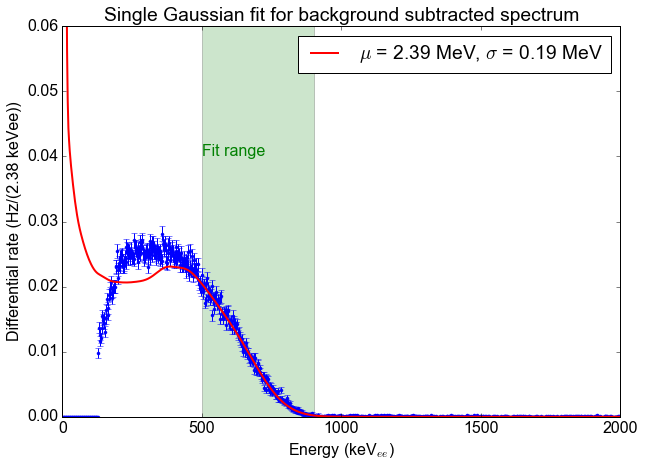

In [17]:
vals = m_sing_sub.values
plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, ls='None', marker='.')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **vals), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu'], vals['sigma']))

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,0.6e-1)
plt.xlim(0,2000)
plt.legend()
#plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Single Gaussian fit for background subtracted spectrum')
plt.savefig('plots/fit_spectrum_sub_sing_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

### High energy population, rebinning method

This is probably the better method to use (other depricated as of July 29, 2016). It is based on the 99 percentile of BG in 50 bins. With this we extend the energy range a lot, all the way down to:

#### Settings

In [18]:
min_e_he  = 2000
max_e_he  = np.inf
# For motivation: see end of this note
min_e_led = 6670
max_e_led = 7980

In [19]:
from scipy.integrate import quad

In [20]:
def integrand(x):
    return 50*get_neutron_spectrum_interpolated_2(x, **m_doub_sub.values)


In [21]:
# Quick and dirty integration but stilll within % level of scipy.integrate.quad (which is super expensive)
# And: note that it's a correction anyway...
to_sub = []
npoints = 100
for e in e_scale_he:
    e_to_eval = np.linspace(e - 25, e+25, npoints)
    to_sub.append(np.average(integrand(e_to_eval)))
to_sub = np.array(to_sub)

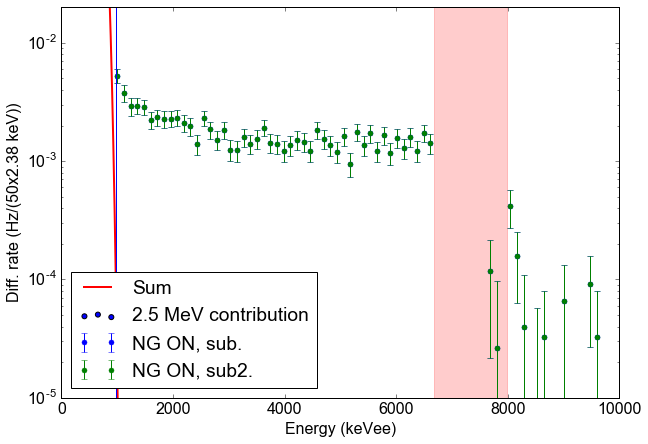

In [22]:
vals = m_doub_sub.values
plt.errorbar(e_scale_he,fg_he_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub.')
plt.errorbar(e_scale_he,fg_he_sub-to_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub2.')

plt.plot(e_scale, 50*get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')
plt.scatter(e_scale_he,to_sub, marker='.', s=100, label='2.5 MeV contribution')
draw_box((min_e_led,max_e_led),(0,1), color='red', alpha=0.2)
plt.axvline(min(e_scale_he)-25)
plt.ylim(0.00001,0.02)
plt.xlim(0,10000)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Diff. rate (Hz/(50x2.38 keV))')
plt.legend(loc='lower left')
plt.show()

In [23]:
mask = ((e_scale_he <min_e_led) | (e_scale_he > max_e_led)) & (e_scale_he > min_e_he) & (e_scale_he < max_e_he)
x = e_scale_he[mask]

y_data = fg_he_sub[mask] - to_sub[mask]
y_err = fg_he_sub_err
# Set errors to one if entry is zero
for i, ye in enumerate(y_err):
    if ye==0:
        y_err[i] = 1/(ng_livetimes[0]+ng_livetimes[1])*1.
        print("WARNING zero entries at %.1f keV" % e_scale_he[i])
y_err = y_err[mask]

WARNING zero entries at 8759.7 keV
WARNING zero entries at 9117.9 keV


(2000.0, 10000.0)

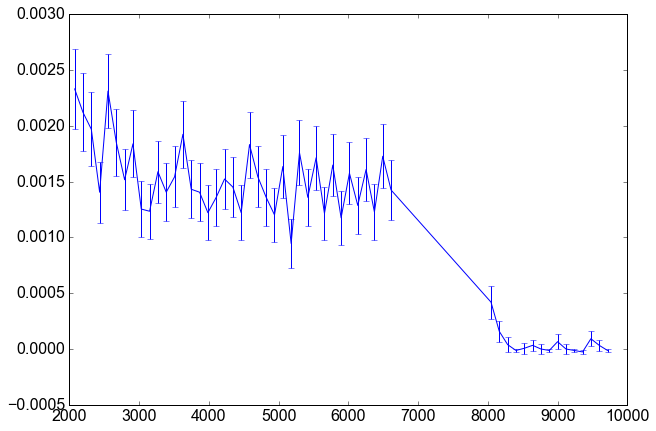

In [24]:
plt.errorbar(x,y_data,y_err)
plt.xlim()

In [25]:
chi2 = Chi2Func(x, y_data, y_err)

In [26]:
# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.4, mu=14.5, sigma=0.1, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)
# Initialize minimizer and minimize
m_high_2 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_high_2.migrad();
print(m_high_2.values)

FCN = 46.53080458329056 
 TOTAL NCALL = 541 
 NCALLS = 541 
 
 
 EDM = 4.6788974482116094e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.679992,0.147411,0,0,,,
2,mu,14.1248,0.00329391,0,0,,,
3,sigma,0.00720099,0.011779,0,0,,,


{'mu': 14.124784556710903, 'sigma': 0.0072009916731271195, 'a': 0.6799924968403773}


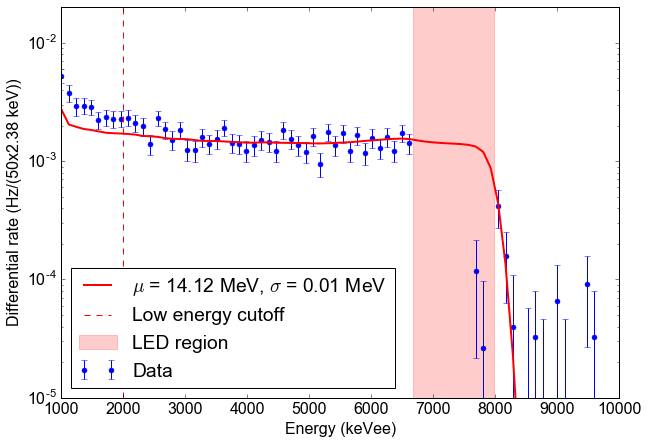

In [27]:
plt.errorbar(e_scale_he,fg_he_sub-to_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='Data')
plt.plot(e_scale_he,get_neutron_spectrum_interpolated(e_scale_he, **m_high_2.values), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (m_high_2.values['mu'],m_high_2.values['sigma']))

draw_box((min_e_led,max_e_led),(0,1), color='red', alpha=0.2, label='LED region')
plt.axvline(min_e_he, ls='--', color='red', label='Low energy cutoff')
plt.ylim(0.00001,0.02)
plt.xlim(1000,10000)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Differential rate (Hz/(50x2.38 keV))')
plt.legend(loc='lower left')

plt.savefig('./plots/he_spec.png', bbox_inches='tight')
plt.show()

#### Sander's request

In [28]:
my_fix_sigma = True

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# 13 MeV
my_args = dict(
    a=0.4, mu=13, sigma=0.01, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1, 
    fix_mu=True, fix_sigma=my_fix_sigma)
m_fix_13 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_fix_13.migrad();

# 14 MeV
my_args = dict(
    a=0.4, mu=14, sigma=0.01, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1, 
    fix_mu=True, fix_sigma=my_fix_sigma)
m_fix_14 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_fix_14.migrad();

# 15 MeV
my_args = dict(
    a=0.4, mu=15, sigma=0.01, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1, 
    fix_mu=True, fix_sigma=my_fix_sigma)
m_fix_15 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_fix_15.migrad();

print(m_fix_13.values)
print(m_fix_14.values)
print(m_fix_15.values)

FCN = 60.552283731676745 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 1.0728599874426825e-11 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.900497,0.0262482,0,0,,,
2,mu,13,0.1,0,0,,,FIXED
3,sigma,0.01,0.01,0,0,,,FIXED


FCN = 51.05039860298135 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 7.47797837998605e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.652632,0.0189469,0,0,,,
2,mu,14,0.1,0,0,,,FIXED
3,sigma,0.01,0.01,0,0,,,FIXED


FCN = 1108.8069084259607 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 5.930459240331027e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.143171,0.0126193,0,0,,,
2,mu,15,0.1,0,0,,,FIXED
3,sigma,0.01,0.01,0,0,,,FIXED


{'mu': 13.0, 'sigma': 0.01, 'a': 0.90049672240681}
{'mu': 14.0, 'sigma': 0.01, 'a': 0.6526316469187325}
{'mu': 15.0, 'sigma': 0.01, 'a': 0.1431708475258337}


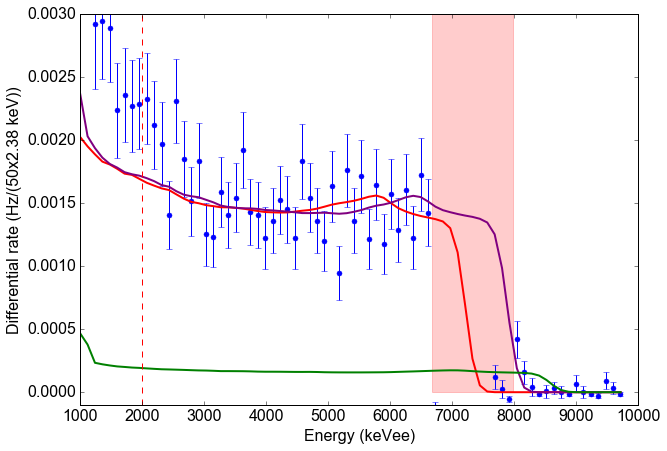

In [29]:
plt.errorbar(e_scale_he,fg_he_sub-to_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='Data')

plt.plot(e_scale_he,get_neutron_spectrum_interpolated(e_scale_he, 
                                                      **m_fix_13.values
                                                     ), color='red', lw=2)

plt.plot(e_scale_he,get_neutron_spectrum_interpolated(e_scale_he, 
                                                      **m_fix_14.values
                                                     ), color='purple', lw=2)

plt.plot(e_scale_he,get_neutron_spectrum_interpolated(e_scale_he, 
                                                      **m_fix_15.values
                                                     ), color='green', lw=2)

draw_box((min_e_led,max_e_led),(0,1), color='red', alpha=0.2, label='LED region')
plt.axvline(min_e_he, ls='--', color='red', label='Low energy cutoff')
plt.ylim(-0.0001,0.003)
plt.xlim(1000,10000)
#plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Differential rate (Hz/(50x2.38 keV))')
#plt.legend(loc='lower left')

plt.savefig('./plots/he_spec.png', bbox_inches='tight')
plt.show()

### Double scatters

In [30]:
double_scatter_response = np.zeros(2*len(e_scale))
single_scatter_response = get_neutron_spectrum_interpolated_2(e_scale, **vals)


# Loop over bins in energy spectrum #1
for i in range(len(single_scatter_response)):
    for j in range(len(single_scatter_response)):
        double_scatter_response[i+j] += single_scatter_response[i] * single_scatter_response[j]
    

### Combine EVERYTHING

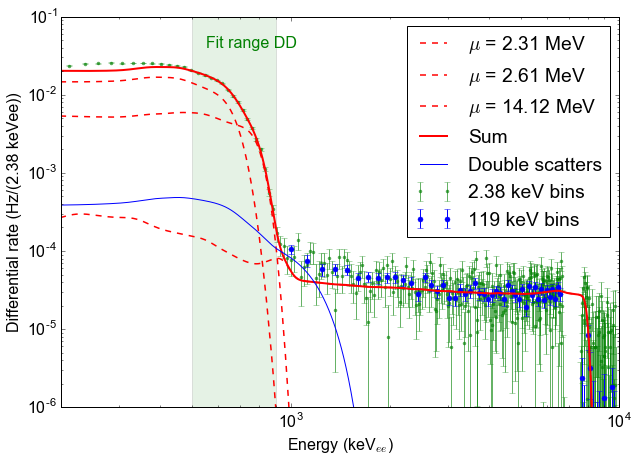

In [31]:
rebin_fac = 10

vals1 = m_doub_sub.values
vals2 = m_high_2.values

# Data (rebinned)
plt.errorbar(rebin(e_scale,rebin_fac), rebin(fg_disc_sub,rebin_fac), rebin(fg_disc_sub_err,rebin_fac, mode='quad_avg'),
             ls='None', marker='.', label='2.38 keV bins', color='green', alpha=0.6)
# High energy data
plt.errorbar(e_scale_he, 0.02*fg_he_sub, 0.02*fg_he_sub_err, ls='None', marker='.', 
             markersize = 10, label='119 keV bins', color='blue')

# Subplots (3 contributions)
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a1'], vals1['mu1'], vals1['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV' % (vals1['mu1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a2'], vals1['mu2'], vals1['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV' % (vals1['mu2']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, 0.02*vals2['a'], vals2['mu'], vals2['sigma']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV' % (vals2['mu']), ls='--')

# Full fit
plt.plot(e_scale, get_neutron_spectrum_interpolated_3(e_scale,
                                                     vals1['a1'], vals1['mu1'], vals1['sigma1'],
                                                     vals1['a2'], vals1['mu2'], vals1['sigma2'],
                                                     0.02*vals2['a'], vals2['mu'], vals2['sigma'], 
                                                     ), color='red', lw=2,
        label='Sum')

# Double scatters
plt.plot(e_scale, 0.2*1/sum(double_scatter_response[:len(e_scale)])*double_scatter_response[:len(e_scale)], 
         label='Double scatters')


draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.1)
plt.text(550, 0.04, 'Fit range DD', color='green')

plt.ylim(1e-6,1e-1)
#plt.xlim(0,9000)
plt.xscale('log')
plt.xlim(200.,1e4)
#plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
#plt.title('Double Gaussian fit for background subtracted spectrum')
plt.legend()

plt.savefig('./plots/all_combined.png', bbox_inches='tight')
plt.show()

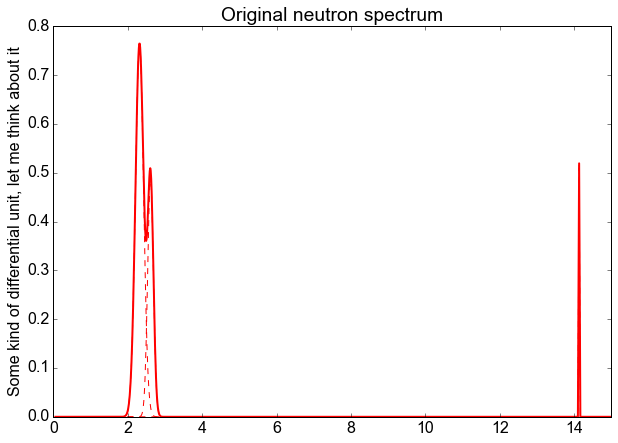

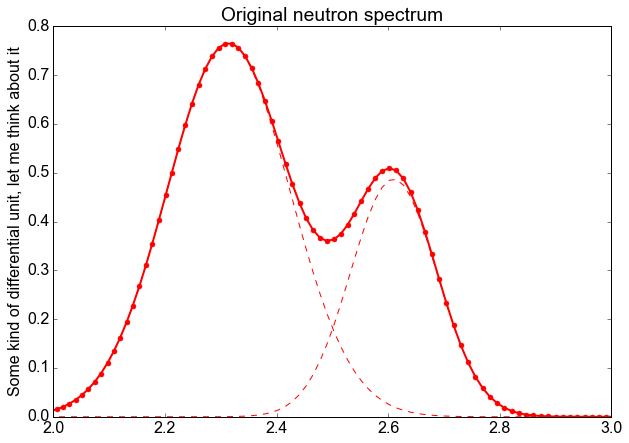

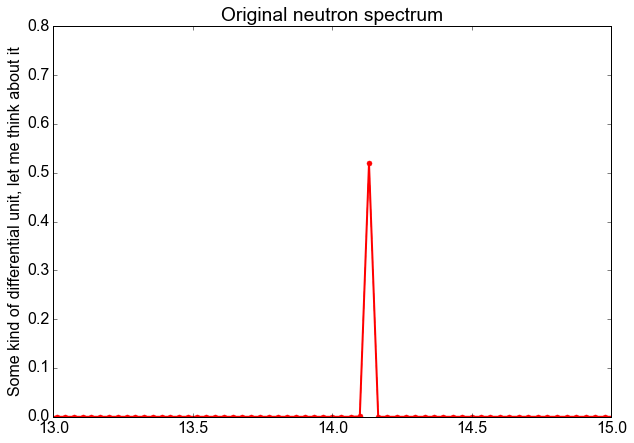

In [32]:
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2)
plt.xlim(0, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2, marker='.', markersize=10)
plt.xlim(2, 3)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2, marker='.', markersize=10)
plt.xlim(13, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

In [33]:
def int_spec(x, y):
    '''
    Integrate spectrum
    '''
    dx = np.diff(x)
    return sum(y[:-1]*dx)

In [34]:
int_gauss1 = int_spec(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']))
int_gauss2 = int_spec(neutron_energies,vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']))
int_gauss3 = int_spec(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']))
int_tot = int_gauss1 + int_gauss2 + int_gauss3

In [35]:
print('Totals: %.1f%% at %.2f MeV; %.1f%% at %.2f MeV; %.1f%% at %.2f MeV' % 
      (int_gauss1/int_tot*100, vals1['mu1'],
      int_gauss2/int_tot*100, vals1['mu2'],
       int_gauss3/int_tot*100, vals2['mu'],
      ))

Totals: 65.4% at 2.31 MeV; 29.3% at 2.61 MeV; 5.3% at 14.12 MeV


### Scatters in NG

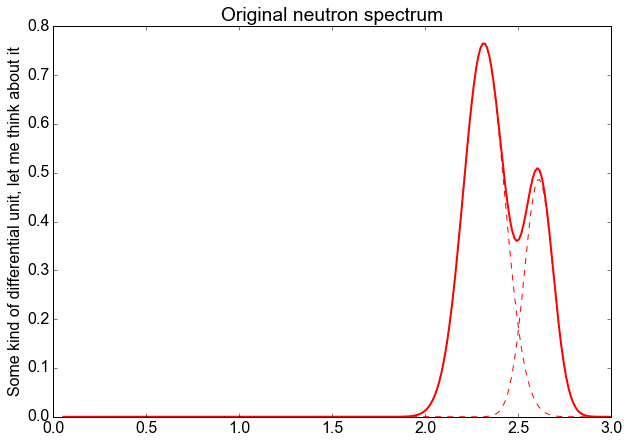

In [36]:
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2'])
         ,c='red',lw=2)
plt.xlim(0, 3)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

In [37]:
def bin_simu(data):
    binned_data = []
    for i in range(len(neutron_energies)-1):
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        e = neutron_energies[i]
        bin_cont = len(data[(data['incidentEnergy']*0.001 >= e - bin_width/2) & 
                            (data['incidentEnergy']*0.001 < e + bin_width/2)])
        binned_data.append(bin_cont/bin_width)
        # DIVIDE BY BIN WIDTH
        # This makes sense, doesn't it? You divide by bin width, cause we later multiply again
        # And besides, what about the Gaussian then?
        
    # Add last bin for mismatch
    binned_data.append(0)
    
    
    
    # NOTE: NEED TO CORRECT FOR BIN WIDTH
    return np.array(binned_data)

In [38]:
def smear_binned_simu(data, sigma):
    y_unsmeared = bin_simu(data)
    y_smeared = np.zeros(len(neutron_energies))
    # For each neutron energy, get a Gaussian with th
    for i in range(len(neutron_energies)-1):
        #bin_width = neutron_energies[i+1] - neutron_energies[i]
        mu = neutron_energies[i]
        a  = y_unsmeared[i]
        y_smeared += (a*gaussian(neutron_energies, mu, sigma))
    return y_smeared

In [39]:
norm_fac1 = int_gauss1/ int_spec(neutron_energies, bin_simu(d_sim[2.31]))
norm_fac1_smear = int_gauss1/ int_spec(neutron_energies, smear_binned_simu(d_sim[2.31], sigma=vals1['sigma1']))

norm_fac2 = int_gauss2/ int_spec(neutron_energies, bin_simu(d_sim[2.61]))
norm_fac2_smear = int_gauss2/ int_spec(neutron_energies, smear_binned_simu(d_sim[2.61], sigma=vals1['sigma2']))

(0, 1)

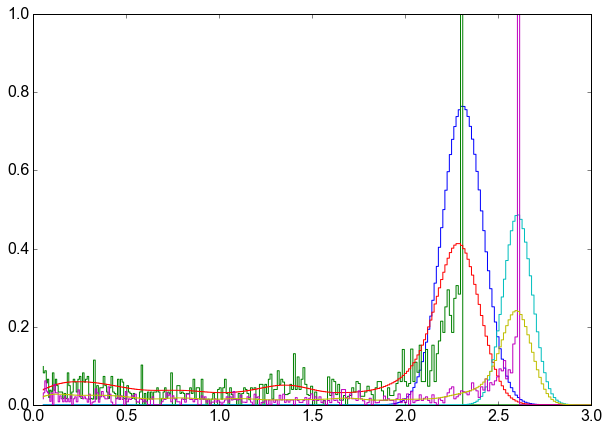

In [40]:
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']), ls='steps')
plt.plot(neutron_energies, norm_fac1*bin_simu(d_sim[2.31]), ls='steps')
plt.plot(neutron_energies, norm_fac1_smear*smear_binned_simu(d_sim[2.31], sigma=vals1['sigma1']), ls='steps')

plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']), ls='steps')
plt.plot(neutron_energies, norm_fac2*bin_simu(d_sim[2.61]), ls='steps')
plt.plot(neutron_energies, norm_fac2_smear*smear_binned_simu(d_sim[2.61], sigma=vals1['sigma2']), ls='steps')

plt.xlim(0,3.0)
plt.ylim(0,1)
#plt.yscale('log')
#plt.ylim(1e-3, 1)

### Random scraps

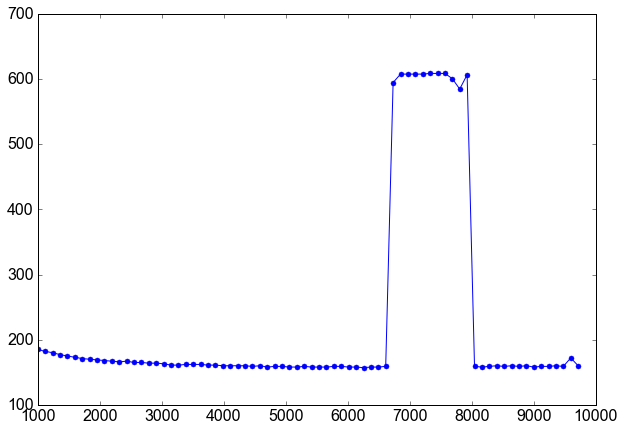

In [41]:
plt.plot(e_scale_he, cutoffs, marker='.', markersize=10)

In [42]:
led_region = e_scale_he[np.array(cutoffs) > 400]

In [43]:
# left bound
print(led_region[0] - 0.5*2.38*50)
print(led_region[-1] + 0.5*2.38*50)

6670.8625
7983.6125


(0, 0.1)

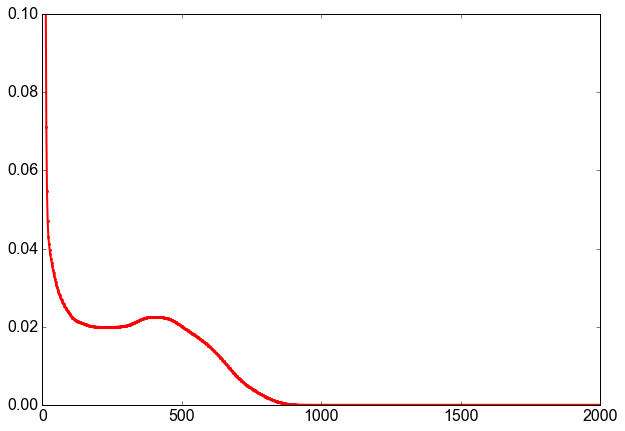

In [44]:
plt.plot(e_scale, get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum', marker='.', markersize=5)
plt.xlim(0,2000)
plt.ylim(0,0.1)

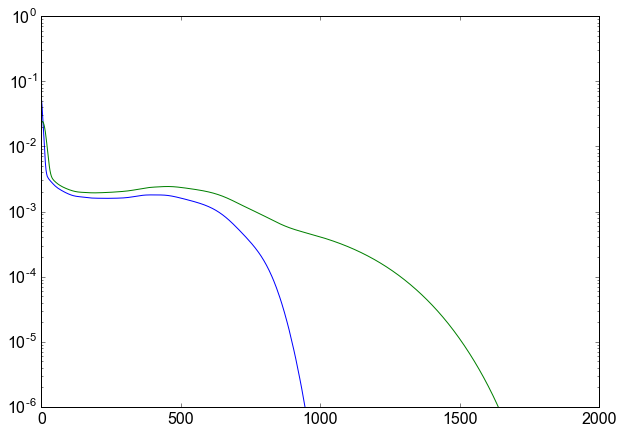

In [45]:
plt.plot(e_scale,1/sum(single_scatter_response[:len(e_scale)])*single_scatter_response[:len(e_scale)])
plt.plot(e_scale, 1/sum(double_scatter_response[:len(e_scale)])*double_scatter_response[:len(e_scale)])
plt.xlim(0,2000)
#plt.ylim(0,0.003)

plt.ylim(1e-6,1)
plt.yscale('log')

In [46]:
import time
print('Current CPU time: %d seconds' % time.clock())

Current CPU time: 204 seconds


### Revisit of fit

In [70]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_disc_sub[sel]
y_err = fg_disc_sub_err[sel]
assert len(fg_disc_sub_err[sel][fg_disc_sub_err[sel] == 0]) == 0

# Initialize chi2 function
if use_err:
    chi2 = Chi2Func_2(x, y_data, y_err)
else:
    chi2 = Chi2Func_no_err_2(x, y_data)

# Give guess parameters
my_args = dict(
    a1=0.15, mu1=2.2, sigma1=0.1, error_a1 = 0.0001, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=0.15, mu2=2.6, sigma2=0.1, error_a2 = 0.0001, error_mu2 = 0.1, error_sigma2 = 0.01,
    errordef=1)
# Initialize minimizer and minimize
m_doub_sub = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m_doub_sub.migrad();
print(m_doub_sub.values)

FCN = 194.83973796002599 
 TOTAL NCALL = 283 
 NCALLS = 283 
 
 
 EDM = 3.259160958747116e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,0.211133,0.040655,0,0,,,
2,mu1,2.3136,0.0309108,0,0,,,
3,sigma1,0.110094,0.0278005,0,0,,,
4,a2,0.0946715,0.0388003,0,0,,,
5,mu2,2.60964,0.0452473,0,0,,,
6,sigma2,0.0775839,0.0293427,0,0,,,


{'mu1': 2.3135968854400066, 'sigma1': 0.11009362966521433, 'mu2': 2.6096446087719047, 'sigma2': 0.0775838851456969, 'a2': 0.09467151533339832, 'a1': 0.21113316522237993}


In [71]:
m_doub_sub.print_matrix()

+,a1,mu1,sigma1,a2,mu2,sigma2
a1,1.00,0.98,0.96,-1.00,0.99,-0.93
mu1,0.98,1.00,0.92,-0.99,0.98,-0.92
sigma1,0.96,0.92,1.00,-0.95,0.91,-0.82
a2,-1.00,-0.99,-0.95,1.00,-0.99,0.94
mu2,0.99,0.98,0.91,-0.99,1.00,-0.96
sigma2,-0.93,-0.92,-0.82,0.94,-0.96,1.00


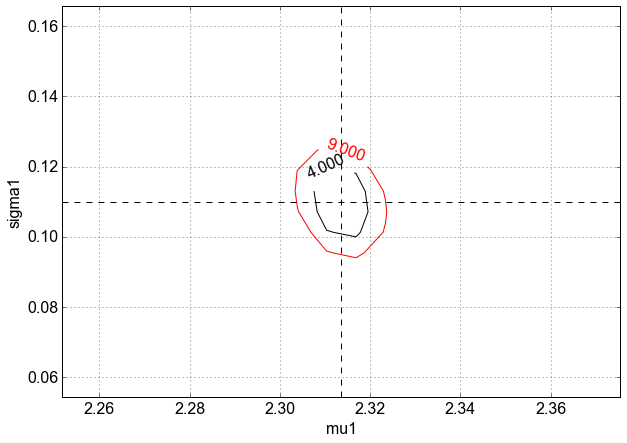

In [74]:
m_doub_sub.draw_contour('mu1', 'sigma1')
plt.show()

In [84]:
v = m_doub_sub.values

chi2(
    v['a1'], v['mu1'], v['sigma1'],v['a2'], v['mu2'], v['sigma2'],
)

194.83973796002599

In [85]:
m_doub_sub.fval

194.83973796002599

In [86]:
mu1_list = np.arange(2.28,2.34,0.01)

chi_list = []
for mu1 in mu1_list:
    chi_list.append(chi2(v['a1'], mu1, v['sigma1'],v['a2'], v['mu2'], v['sigma2']))


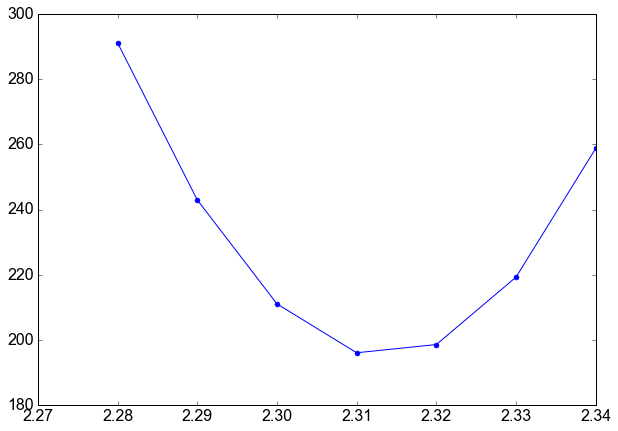

In [88]:
plt.plot(mu1_list, chi_list, marker='.', markersize=10)
plt.show()

In [89]:
np.linspace?

In [126]:
from tqdm import tqdm

In [142]:
v =  m_doub_sub.values
ve = m_doub_sub.errors

In [144]:

v['mu1'] - nsig * ve['mu1']


2.2208644204085637

In [202]:
nsig = 4
nsig_step = 1
npar = 6
xy = np.mgrid[
    v['a1'] - nsig * ve['a1'] : v['a1'] + nsig * ve['a1'] : nsig_step*ve['a1'],
    v['mu1'] - nsig * ve['mu1'] : v['mu1'] + nsig * ve['mu1'] : nsig_step*ve['mu1'], 
    v['sigma1'] - nsig * ve['sigma1'] : v['sigma1'] + nsig * ve['sigma1'] : nsig_step*ve['sigma1'],
    v['a2'] - nsig * ve['a2'] : v['a2'] + nsig * ve['a2'] : nsig_step*ve['a2'],
    v['mu2'] - nsig * ve['mu2'] : v['mu2'] + nsig * ve['mu2'] : nsig_step*ve['mu2'], 
    v['sigma2'] - nsig * ve['sigma2'] : v['sigma2'] + nsig * ve['sigma2'] : nsig_step*ve['sigma2'],

].reshape(npar,-1).T
newshape = np.shape(xy)
# dp is datapoints
dp = np.zeros((newshape[0],newshape[1]+1))
dp[:,:npar] = xy
for el in tqdm(dp):
    el = abs(el)
    el[-1] = (chi2(el[0], el[1], el[2], el[3], v['mu2'], v['sigma2']))
print(min(dp[:,-1]))
    
pickle.dump( dp, open( "save.p", "wb" ) )

  9%|▉         | 26289/294912 [14:22<2:41:40, 27.69it/s]

KeyboardInterrupt: 

In [205]:
min(dp[:,-1][dp[:,-1] != 0])

ValueError: min() arg is an empty sequence

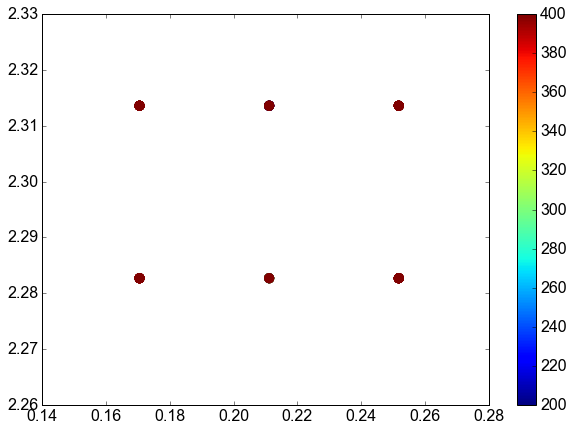

In [179]:
plt.scatter(dp[:,0], dp[:,1], c=dp[:,-1], edgecolor='None', s=100, vmin=200, vmax=400)
plt.colorbar()
#m_doub_sub.draw_contour('mu1', 'sigma1', show_sigma=True)
plt.show()

In [176]:
min(dp[:,-1])

194.83973796002599

In [169]:
dp[:,-1]

array([ 19672.24916097,  19672.24916097,  19672.24916097, ...,
        30198.97248782,  30198.97248782,  30198.97248782])

In [173]:
dp[0]

array([  8.91682167e-02,   2.22086442e+00,   2.66921725e-02,
         1.96722492e+04])

In [193]:
d_from_min = np.sqrt(((dp[:,0]-v['a1'])/ve['a1'])**2 + 
                     ((dp[:,1]-v['mu1'])/ve['mu1'])**2 + 
                     ((dp[:,2]-v['sigma1'])/ve['sigma1'])**2 + 
                     ((dp[:,3]-v['a2'])/ve['a2'])**2 + 
                     ((dp[:,4]-v['mu2'])/ve['mu2'])**2 + 
                     ((dp[:,5]-v['sigma2'])/ve['sigma2'])**2 )
   

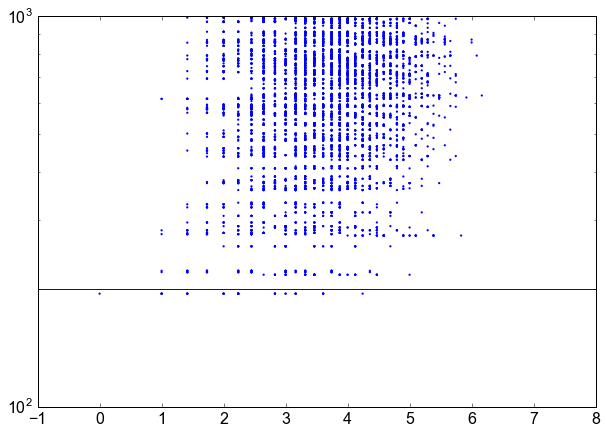

In [195]:
plt.scatter(d_from_min, dp[:,-1], s=5, edgecolors='None')
plt.yscale('log')
plt.ylim(100,1000)
plt.axhline(200)

In [197]:
v['sigma2']

0.0775838851456969

In [198]:
ve['sigma2']

0.02934269110414649

In [196]:
dp[dp[:,-1]<200]

array([[  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.47390261e+00,  -1.04441882e-02,
          1.94839738e+02],
       [  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.47390261e+00,   1.88985029e-02,
          1.94839738e+02],
       [  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.47390261e+00,   4.82411940e-02,
          1.94839738e+02],
       [  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.47390261e+00,   7.75838851e-02,
          1.94839738e+02],
       [  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.47390261e+00,   1.06926576e-01,
          1.94839738e+02],
       [  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.47390261e+00,   1.36269267e-01,
          1.94839738e+02],
       [  2.11133165e-01,   2.31359689e+00,   1.10093630e-01,
          9.46715153e-02,   2.51